# Case 1

- Open the TFP.csv file attached.

- The series is composed by TFP (rtfpna variable) at constant national prices (2005 = 1) for three countries: United States (USA), Canada (CAN) and Mexico (MEX).

1.1 Make an exploratory data analysis;

1.2 Forecast 10 years of the series (if you are performing the exercise in R, use package “forecast”);

1.3 Check in the following link pages 2 and 3: https://cran.r-project.org/web/packages/pwt8/pwt8.pdf to see a list of all variables in the original dataset. Can you think about another feature that could be helpful in explaining TFP series? Explain.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import statsmodels.api as sm

In [2]:
%matplotlib inline
sns.set()
sns.set_style('white')

# set figure size
figs = (12,5)

In [3]:
df = pd.read_csv('assets/TFP.csv', parse_dates=['year'])

## Descriptive statistics

In [4]:
df.head()

,isocode,year,rtfpna
0,USA,1950-01-01,0.617148
1,USA,1951-01-01,0.629588
2,USA,1952-01-01,0.638451
3,USA,1953-01-01,0.651858
4,USA,1954-01-01,0.646179


First, we will pivot the data to analyze the time series individually:

In [5]:
df = df.pivot(columns='isocode', index='year', values='rtfpna')
df.head()

isocode,CAN,MEX,USA
year,,,
1950-01-01,0.843335,0.798159,0.617148
1951-01-01,0.855123,0.860931,0.629588
1952-01-01,0.896489,0.876968,0.638451
1953-01-01,0.910658,0.855204,0.651858
1954-01-01,0.875178,0.929168,0.646179


Now, the descriptive statistics:

In [6]:
df.describe()

isocode,CAN,MEX,USA
count,62.000000,62.000000,62.000000
mean,0.992886,1.130132,0.803824
std,0.050126,0.158209,0.116121
min,0.843335,0.798159,0.617148
25%,0.973294,1.012231,0.739949
50%,1.004211,1.093859,0.766047
75%,1.029513,1.299591,0.880544
max,1.066104,1.383718,1.020392


Are the time series linearly correlated?

In [7]:
df.corr()

isocode,CAN,MEX,USA
isocode,,,
CAN,1.000000,0.642937,0.334445
MEX,0.642937,1.000000,-0.259193
USA,0.334445,-0.259193,1.000000


Here, we inspect the time series, in level and first order difference:

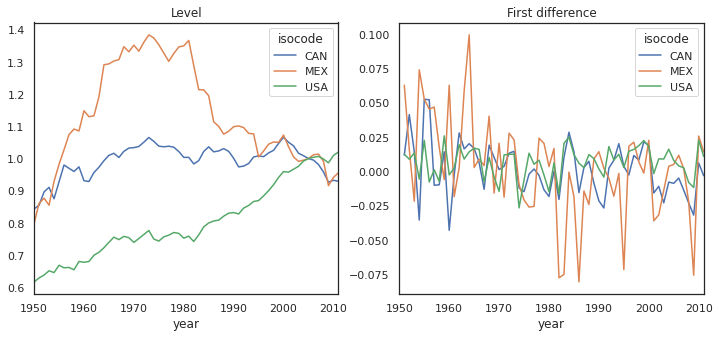

In [8]:
fig, ax = plt.subplots(1,2, figsize=figs)

df.plot(ax=ax[0], title='Level')
df.diff().plot(ax=ax[1], title='First difference')

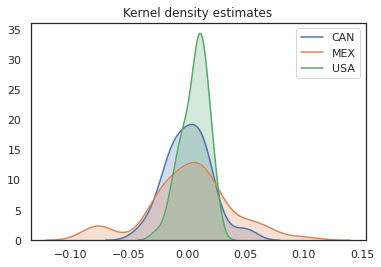

In [9]:
plt.title('Kernel density estimates')
[sns.kdeplot(df[series].diff(), shade=True) for series in df.columns]

In general, data shows greater uncertainty in Canada and Mexico total productivity growth.

## Time series analysis

Before diving into time series modelling, we should inspect the series key characteristics, such as stationariety and cointegration.

Upon earlier inspection, it is reasonable to assume the time series are non-stationary, as they exhibit well-defined trends. Nevertheless, we run statistical test for stationariety, namely the augmented Dickey and Fuller test, with constant and trend. The following are the MacKinnon (1994) p-values.

In [10]:
{series: sm.tsa.stattools.adfuller(df[series], regression='ct')[1] for series in df.columns}

{'CAN': 0.40231219825326797,
 'MEX': 0.40455390107688016,
 'USA': 0.8564670460105449}

Under a 95% confidence interval, we can reject the null hypothesis that each time series is stationary.

Next, we investigate cointegration relationships between time series. Cointegration analysis aims to find a long-term relationship between two time series. I then run the Engle and Granger (1991) cointegration test for all combinations of time series.

In [11]:
from itertools import combinations

In [12]:
combs = [*combinations(df.columns, 2)]
{s1+' and '+s2: sm.tsa.stattools.coint(df[s1], df[s2])[1] for s1, s2 in combs}

{'CAN and MEX': 0.34039072636371265,
 'CAN and USA': 0.34335400101285196,
 'MEX and USA': 0.27111508418576913}

Analyzing the p-values I'm unable to find cointegrating relationships between TFP series. Hence, I will discard forecasting using multivariate time series models, such as vector autoregressions.

## Forecasting

/home/angelo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/angelo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/angelo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/angelo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/angelo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information

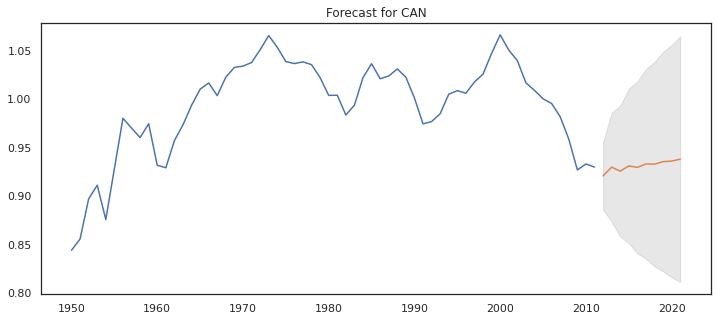

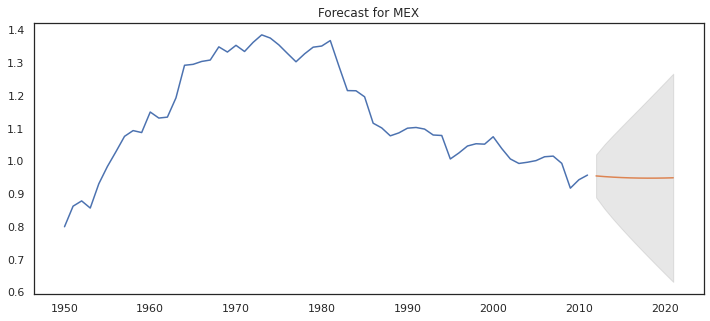

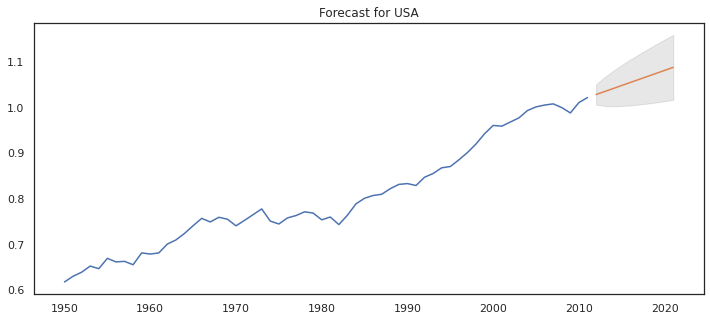

In [13]:
# for each time series
for series in df.columns:
    # find order

    # declar model
    model = sm.tsa.SARIMAX(df[series], order=(1,1,1), trend='c')
    steps = 10

    # fit model
    mod_fit = model.fit()
    forecast = mod_fit.get_forecast(steps).summary_frame()
    
    # plot forecast
    fig, ax = plt.subplots(figsize=figs)
    plt.title('Forecast for '+series)
    plt.plot(df[series])
    plt.plot(forecast['mean'])
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)

# _TODO: Argue other variables!!_

# Case 2

Attached to this test is a .csv file which contains data from Comexstat, which is basically the official data source for brazilian exports e imports, maintened by the government;

The dataset contains all trackings of monthly imports and exports of a range of products (soybeans, soybean meal, soybean oil, corn, wheat and sugar), by brazilian states, by routes (air, sea, ground, etc) e from/to which country;

We ask you to address a couple quentions below. Remember that data viz is one important skill to show besides any analytical skill. So we encourage you to use and explore a bunch of graphs and tables to show your point.

Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’;

What are the 3 most important products exported by Brazil in the last 5 years?

What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importancem of routes depending on the product?

Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

For each of the products in the dataset, show the 5 most important states in terms of exports?

Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [172]:
comex = pd.read_csv('assets/data_comexstat.csv',
                    parse_dates=['date'], low_memory=False, encoding='iso-8859-1')

In [175]:
comex.head()

,date,product,state,country,type,route,tons,usd,price per ton,year
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0,2566.216370,1997
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0,680.000000,1997
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0,900.000000,1997
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0,1630.733945,1997
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0,690.000000,1997


In [174]:
comex['price per ton'] = comex['usd']/comex['tons']
comex['year'] = comex['date'].dt.year

- Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

In [176]:
tmpdf = comex.query("type=='Export' and (product == 'soybeans'\
            or product == 'soybean oil' or product == 'soybean meal')")\
    .groupby(['date'])\
    .sum()/1E6

Text(0, 0.5, 'Million tonnes')

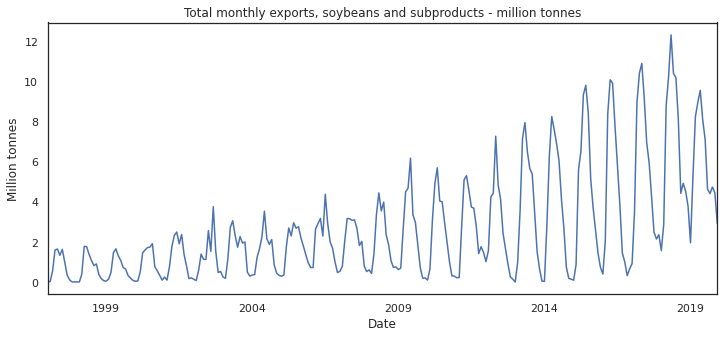

In [177]:
tmpdf['tons'].plot(title='Total monthly exports, soybeans and subproducts - million tonnes', figsize=figs)
plt.xlabel('Date')
plt.ylabel('Million tonnes')

Text(0, 0.5, 'US$ millions')

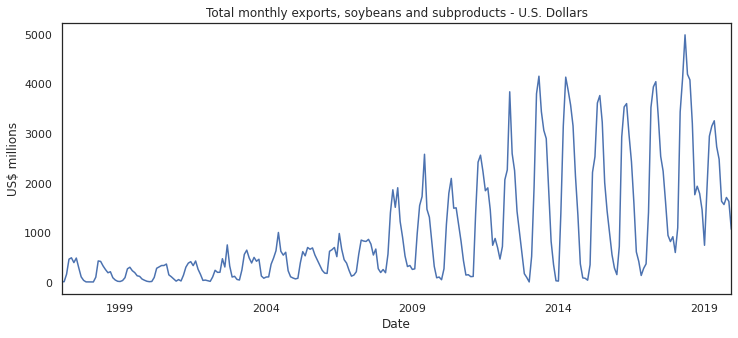

In [178]:
tmpdf['usd'].plot(title='Total monthly exports, soybeans and subproducts - U.S. Dollars', figsize=figs)
plt.xlabel('Date')
plt.ylabel('US$ millions')

- What are the 3 most important products exported by Brazil in the last 5 years?

In [216]:
tmpdf = comex.query("type=='Export' and year > 2015")\
    .groupby(['year','product'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='product', values='usd')/1E6

Text(0, 0.5, 'US$ millions')

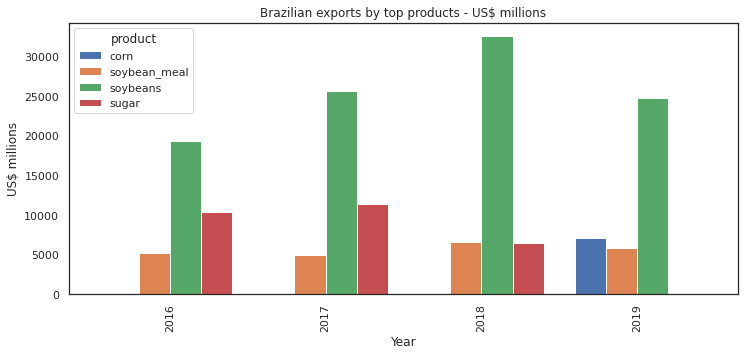

In [217]:
tmpdf.plot(kind='bar', figsize=figs, title='Brazilian exports by top products - US$ millions', width=.8)
plt.xlabel('Year')
plt.ylabel('US$ millions')

- What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importance of routes depending on the product?

In [218]:
tmpdf = comex.query("type=='Export' and product == 'corn' and year > 2015")\
    .groupby(['date','route'])\
    .sum()/1E6

Text(0, 0.5, 'Million tonnes')

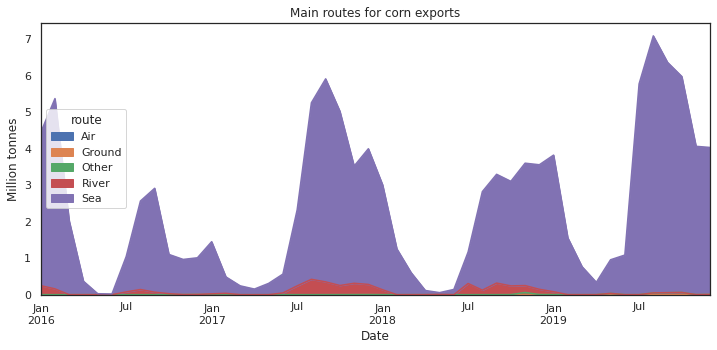

In [223]:
tmpdf.unstack()['tons'].plot(kind='area', figsize=figs, title='Main routes for corn exports')
plt.xlabel('Date')
plt.ylabel('Million tonnes')

- Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

In [234]:
# corn exports
tmpdf = comex.query("product == 'corn' and date > '2016-01-01' and type == 'Export'")\
    .groupby(['year','country'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='country', values='usd')/1E6

# corn imports
tmpdf2 = comex.query("product == 'corn' and date > '2016-01-01' and type == 'Import'")\
    .groupby(['year','country'])\
    .sum()['usd']\
    .groupby(level=0, group_keys=False)\
    .nlargest(3)\
    .reset_index()\
    .pivot(index='year', columns='country', values='usd')/1E6

Text(0, 0.5, 'a')

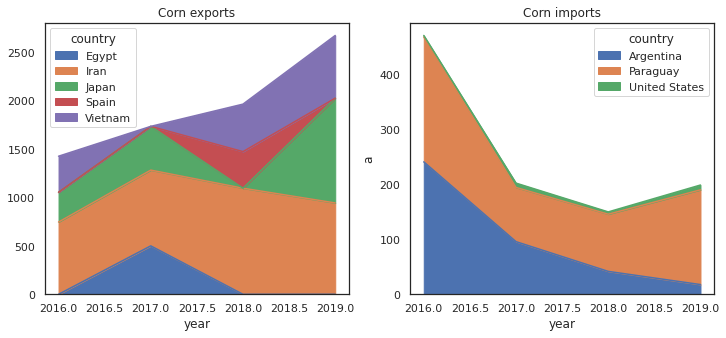

In [240]:
fig, ax = plt.subplots(1,2, figsize=figs)
tmpdf.plot(kind='area', title='Corn exports', ax=ax[0])
plt.ylabel('b')

tmpdf2.plot(kind='area', title='Corn imports', ax=ax[1])
plt.ylabel('a')

- For each of the products in the dataset, show the 5 most important states in terms of exports?

In [155]:
tmpdf = comex.query("type=='Export'")\
    .set_index('state')\
    .groupby(['date','product'])['usd']\
    .nlargest(5)
tmpdf

date        product  state
1997-01-01  corn     PR       20000000.0
                     PR         386733.0
                     RS         142400.0
                     SP          38728.0
                     MS          38700.0
                                 ...    
2019-12-01  wheat    RS        6963002.0
                     PR           1433.0
                     PR            931.0
                     SP            477.0
                     PR            400.0
Name: usd, Length: 7326, dtype: float64

- Now, we ask you to show your modelling skills. Feel free to use any type of modelling approach, but bear in mind that the modelling approach depends on the nature of your data, and so different models yield different estimates and forecasts. To help you out in this task we also provide you with a dataset of possible covariates (.xlsx). They all come from public sources (IMF, World Bank) and are presented in index number format. Question: What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? We’re mostly interested in the annual forecast.

In [26]:
covariates = pd.read_excel('assets/covariates.xlsx')

In [27]:
covariates.head()

,year,price_soybeans,price_corn,price_soybean_meal,gdp_china,gdp_iran,gpd_netherlands,gdp_spain,gdp_thailand,gdp_world,gdp_egypt,gdp_japan,gdp_vietnam
0,1979,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1980,100.000000,100.000000,100.000000,107.900000,81.200000,100.000000,101.200000,104.600000,102.100000,103.400000,103.200000,96.500000
2,1981,98.525508,103.888308,99.805440,113.402900,74.216800,99.500000,100.795200,110.771400,104.039900,105.674800,107.534400,102.097000
3,1982,83.406192,85.986430,86.596956,123.609161,83.939201,98.206500,102.004742,116.753056,104.664139,113.389060,111.083035,110.468954
4,1983,97.851743,108.168059,98.663318,136.958950,95.522811,99.974217,103.738823,123.291227,107.594735,123.480687,114.970941,118.312250


For this exercise, I will aggregate `comex` into an yearly dataset, for joining data with `covariates`.

In [28]:
comex['year'] = comex['date'].dt.year
comex_yearly = comex.groupby(['year', 'product', 'state', 'country', 'type', 'route']).agg({'tons': 'sum', 'usd': 'sum'}).reset_index()

In [29]:
df = pd.merge(comex, covariates, how='left', on='year')

In [30]:
df.columns

Index(['date', 'product', 'state', 'country', 'type', 'route', 'tons', 'usd',
       'year', 'price_soybeans', 'price_corn', 'price_soybean_meal',
       'gdp_china', 'gdp_iran', 'gpd_netherlands', 'gdp_spain', 'gdp_thailand',
       'gdp_world', 'gdp_egypt', 'gdp_japan', 'gdp_vietnam'],
      dtype='object')